In [76]:
import torch
from sklearn.cluster import KMeans

import numpy as np
import matplotlib.pyplot as plt
from clustertools import *

In [2]:
from transformers import FlaubertModel, FlaubertTokenizer

In [3]:
modelname = 'flaubert/flaubert_base_cased' 

In [4]:
flaubert, log = FlaubertModel.from_pretrained(modelname, output_loading_info=True)

Some weights of the model checkpoint at flaubert/flaubert_base_cased were not used when initializing FlaubertModel: ['pred_layer.proj.weight', 'pred_layer.proj.bias']
- This IS expected if you are initializing FlaubertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing FlaubertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
flaubert_tokenizer = FlaubertTokenizer.from_pretrained(modelname, do_lowercase=False)

In [6]:
flaubert.save_pretrained("flaubert_pretrained_model")

In [21]:
#méthode github flaubert

def encode_sentence(sentence):
    token_ids = torch.tensor([flaubert_tokenizer.encode(sentence)])

    last_layer = flaubert(token_ids)[0]
    return last_layer[:, 0, :]

def encode_dataset(dataset):
    dataset_encoded = []
    for tweet in dataset:
        dataset_encoded.append(encode_sentence(tweet))
    return dataset_encoded

In [8]:
#répertoire dans lequel seront stockés les clusters, doit se terminer obligatoirement par /
#cluster_dir = "clusters_transformer_haine_arab/"
#clean_dataset_file = "clean_t_haine2022_ovesampling_arab.csv"
#raw_dataset_file = "haine2022_ovesampling_arab.csv"

#répertoire dans lequel seront stockés les clusters, doit se terminer obligatoirement par /
cluster_dir = "clusters/1M_Std_clusters/som_400/"
#clean_dataset_file = "clusters/1M_Std_clusters/som_400/som_400_cluster_349_raw_msg.txt"
raw_dataset_file = "clusters/1M_Std_clusters/som_400/som_400_cluster_349_raw_msg.txt"

In [9]:
#with open(clean_dataset_file, "r") as file:
#    lines = file.readlines()
    
#global_clean_sample = [line.split() for line in lines]
#clean_sample = [line[:-1] for line in lines if line[-1] == '\n']

with open(raw_dataset_file, "r") as file:
    raw_dataset = file.read().splitlines()
    
clean_dataset = [line.split() for line in raw_dataset]

In [22]:
%%time
encoded_dataset = encode_dataset(raw_dataset)

CPU times: user 1min 44s, sys: 131 ms, total: 1min 44s
Wall time: 26.2 s


In [17]:
from sklearn.decomposition import PCA

In [50]:
np_encoded_dataset = np.array([e[0].detach().numpy() for e in encoded_dataset])

In [51]:
np_encoded_dataset

array([[-2.1631227 ,  0.8819384 ,  0.5645729 , ..., -2.2873962 ,
         0.4827898 ,  0.85433507],
       [-0.05515409, -0.27758142, -0.2079796 , ..., -2.2265449 ,
         0.5246044 ,  2.378861  ],
       [-0.19456512,  1.0856546 , -0.08006809, ..., -0.93637925,
        -0.40527076,  1.9488416 ],
       ...,
       [ 0.47187608, -0.51984996, -2.1590195 , ..., -0.62165064,
        -0.69177866,  0.8775446 ],
       [ 0.2733845 , -1.1197681 , -0.2154261 , ..., -1.7609248 ,
         1.6877371 ,  0.20899786],
       [-1.795198  ,  0.54182094, -0.40731096, ..., -1.7043077 ,
        -0.64929324,  0.39033082]], dtype=float32)

In [54]:
%%time

pca = PCA(n_components=2)

#On crée une version en deux dimensions de notre jeu de données
two_dim_dataset = pca.fit_transform(np_encoded_dataset)

CPU times: user 576 ms, sys: 1.13 s, total: 1.71 s
Wall time: 302 ms


In [57]:
#On utilise la matrice transposée de notre jeu de données pour pouvoir visualiser les données
b = two_dim_dataset.T

#Taille des figures
plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams["lines.markersize"] = 3

In [60]:
init_globals(clean_dataset, raw_dataset, two_dim_dataset, cluster_dir)

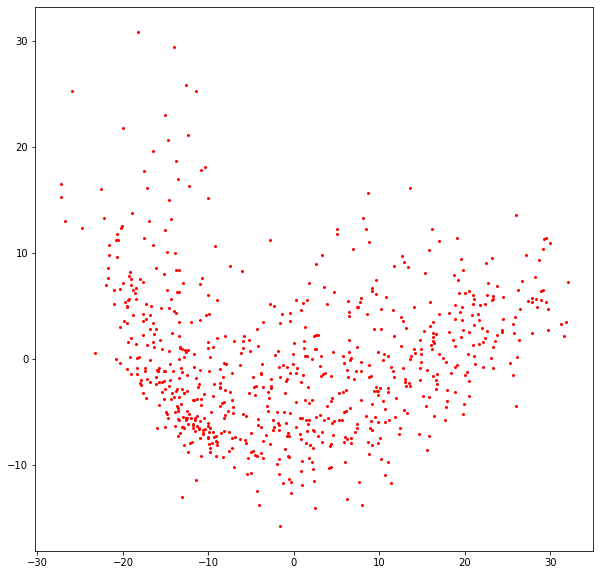

In [61]:
#Affichage des données
plt.plot(b[0], b[1], 'r.')
plt.show()

In [62]:
from sklearn_som.som import SOM

In [64]:
som_normalized_dataset = np.array([vect / np.linalg.norm(vect) if np.linalg.norm(vect) != 0 else vect for vect in np_encoded_dataset])

In [70]:
%%time

som = SOM(m=2, n=3, dim=768)
som.fit(som_normalized_dataset)

CPU times: user 596 ms, sys: 0 ns, total: 596 ms
Wall time: 595 ms


In [71]:
%%time

som_pred = som.predict(som_normalized_dataset)

CPU times: user 26.5 ms, sys: 0 ns, total: 26.5 ms
Wall time: 24.9 ms


Cluster 0 : 174 messages
37 messages contiennent un mot-clé haineux (soit 21.26%)
Les 20 mots les plus fréquents : niquez j’ai enculé te Les tout mer me Oh si lui bz suis mais c'est TA MÈRE sale Mais comme 


Cluster 1 : 52 messages
9 messages contiennent un mot-clé haineux (soit 17.31%)
Les 20 mots les plus fréquents : #SPACEAFROOO moi lui insulter pour ce bz sale Oh dans Mais vraiment chaque « » niquez après va j’ai fait 


Cluster 2 : 192 messages
48 messages contiennent un mot-clé haineux (soit 25.00%)
Les 20 mots les plus fréquents : pour « du mon plus dit On te fait mais C’est » Ma elle va tu trop fils sur ton 


Cluster 3 : 94 messages
22 messages contiennent un mot-clé haineux (soit 23.40%)
Les 20 mots les plus fréquents : vie elle trop tu enculé faut c mer suis oh SA MÈRE quoi niquez j'la aussi va bon Les sur 


Cluster 4 : 105 messages
30 messages contiennent un mot-clé haineux (soit 28.57%)
Les 20 mots les plus fréquents : Oh fait bz trop mais tu va MÈRE C SA plus DE Ta auss

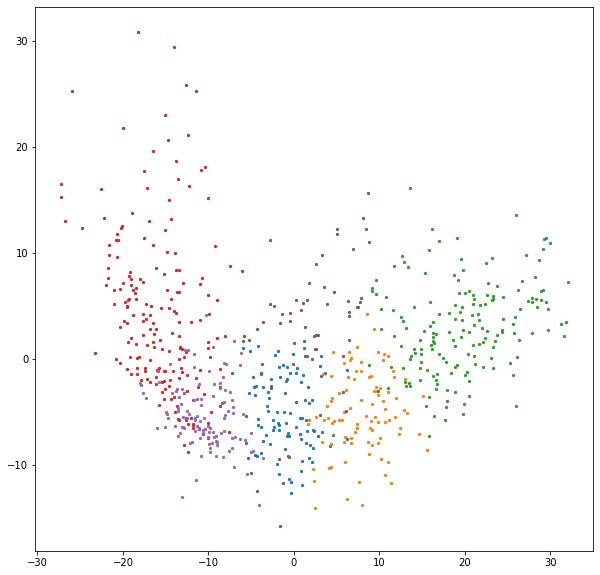

In [73]:
parse_results(som_pred, "som_6_flaubert", [])

### Kmeans

In [77]:
n_clust = 4

In [79]:
%%time
km_model = KMeans(n_clusters=n_clust, random_state=0)
kmeans = km_model.fit(np_encoded_dataset)

CPU times: user 3.6 s, sys: 3.22 s, total: 6.82 s
Wall time: 942 ms


In [80]:
km_pred = kmeans.predict(np_encoded_dataset)

In [28]:
#km_centers = c = [[r[0] for r in w2v.similar_by_vector(center)] for center in km_model.cluster_centers_]

Cluster 0 : 174 messages
36 messages contiennent un mot-clé haineux (soit 20.69%)
Les 20 mots les plus fréquents : niquez te bz j’ai Les tout mer c'est si enculé lui me suis TA MÈRE sale Mais comme mdr va 


Cluster 1 : 245 messages
59 messages contiennent un mot-clé haineux (soit 24.08%)
Les 20 mots les plus fréquents : Oh tu fait trop sale vie MÈRE suis SA #SPACEAFROOO ce lui bz aussi mais mer va niquez pour Les 


Cluster 2 : 91 messages
23 messages contiennent un mot-clé haineux (soit 25.27%)
Les 20 mots les plus fréquents : On te mais mon leur Ma Les sur comment Moi trop Mais c vie y’a dans qu’il va bz quand 


Cluster 3 : 218 messages
55 messages contiennent un mot-clé haineux (soit 25.23%)
Les 20 mots les plus fréquents : pour dit elle plus Ma « sale tu du me va salope dans mais lui » C'est mon même c'est 




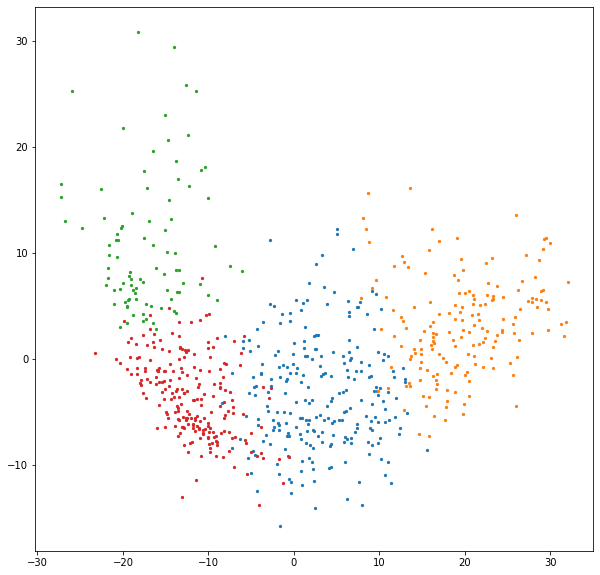

In [81]:
parse_results(km_pred, "km_4_flaubert", [])

In [54]:
res = build_res_dict(km_pred)

In [35]:
wlists, mlists, cmlists, e2dmlists, mfw, hkw, clust_n_msg = parse(km_pred)

In [36]:
print_clusters_info(clust_n_msg, mfw, hkw, [])

In [50]:
for m in mfw.values(): print(m)

['MÈRE', 'mer', 'DE', 'LA', 'salope', 'c', 'pour', 'oh', 'mais', 'du', 'Mais', 'suis', 'On', '#SPACEAFROOO', 'PUTE', 'Ah', 'lui', 'ca', 'bz', 'me']
['mer', 'MÈRE', 'tu', 'lui', 'mais', 'C’est', 'enculé', 'Les', 'va', 'Oh', 'SA', 'bon', 'sale', 'plus', 'trop', 'du', 'elle', 'tout', "c'est", 'c']
['sale', 'Ma', 'te', 'dit', 'me', 'elle', 'trop', 'pour', 'va', 'tu', '«', 'niquez', 'j’ai', 'avec', '»', 'mais', 'Ta', 'vie', 'Oh', 'Le']
['plus', 'mon', 'niquez', 'Ta', 'Ma', 'si', 'dans', 'aussi', 'dit', 'lui', 'leur', 'ce', 'Les', 'bz', 'ton', 'père', 'Oh', 'Mais', 'fait', 'Vos']


In [52]:
save_clusters_info(clust_n_msg, mfw, hkw, "km_4_transformer", centers=[])

In [55]:
plot_results(res)

In [82]:
len(np_encoded_dataset)

728